In [1]:
import os
import time

RAND_SEED = 12345
import numpy as np
np.random.seed(RAND_SEED)
import random
random.seed(RAND_SEED)
import pandas as pd

from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn import ensemble
from sklearn.cluster import DBSCAN

In [2]:
# Define directories and file names
cwd = os.getcwd()
DataFolder = os.path.join(cwd, 'data')
InputDataFile = os.path.join(DataFolder, 'Well_Rates.csv')

In [3]:
df = pd.read_csv(InputDataFile)

In [4]:
# Create input feature and target - comment/uncomment the X,y combination desired
X = df[["BHP", "WHP", "WHT", "Tsep", "Psep", "Choke_in"]]
#X = df[["WHP", "Psep"]]
#X = df[["WHP", "Psep", "Choke_in"]]
#X = df[["BHP", "WHP"]]
#X = df[["BHP", "WHP", "Choke_in"]]
#X = df[["WHP", "WHT", "Tsep", "Psep"]]
#X = df[["WHP", "WHT", "Tsep", "Psep", "Choke_in"]]
y = np.array(df[["Qoil"]].values).reshape(-1, )
#y = np.array(df[["Qwater"]].values).reshape(-1, )
#y = np.array(df[["Qgas"]].values).reshape(-1, )

In [5]:
# Scale Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca)

In [7]:
# Cluster PCA data using DBSCAN
clustering = DBSCAN(eps=0.5, min_samples=12).fit(X_pca)
pca_df["DBSCAN"] = clustering.labels_ + 1

In [8]:
# Filter few clusters: Keep rows where cluster criteria is met
clust_df = pca_df[(pca_df["DBSCAN"] == 1)]

In [9]:
# Delete text column "DBSCAN"
clust_df.drop(columns=["DBSCAN"],inplace=True)

In [10]:
# Create a matriz (X_merge) with all input data (X) plus all computed columns
X_merge = X.merge(pca_df,left_index=True,right_index=True)
X_merge["Labelled Y"] = y

In [11]:
# Bring only the Xrows selected as per Clust_df --> X.iloc[clust_df.index.tolist(),:]
# Clust_df has the size of the cleaned data set, but the real data is in X and y
# Bring only the Yrows selected as per Clust_df --> y[clust_df.index.tolist()
X_selected = X.iloc[clust_df.index.tolist(),:]
y_selected = y[clust_df.index.tolist()]

In [12]:
# Split data for training and testing
train_X, test_X, train_y, test_y = train_test_split(X_selected, y_selected, test_size=0.5, random_state=123)

In [13]:
# #############################################################################
### Randon Forest Regression
# #############################################################################
model_RF = RF(n_estimators=200, random_state=123)
model_RF.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [14]:
# Predict for blind test and train input features
pred_y_RF_test = model_RF.predict(test_X)
pred_y_RF_train = model_RF.predict(train_X)
pred_y_RF_all = model_RF.predict(X.iloc[clust_df.index.tolist(),:])

In [15]:
# Compute  r2 scores  
r2_RF_train = r2_score(train_y, pred_y_RF_train)
r2_RF_test = r2_score(test_y, pred_y_RF_test)
r2_RF_all = r2_score(y[clust_df.index.tolist()], pred_y_RF_all)
print("R^2 for train data Random Forest is %f." %r2_RF_train)
print("R^2 for blind test data Random Forest is %f." %r2_RF_test)
print("R^2 for all data Random Forest is %f." %r2_RF_all)

R^2 for train data Random Forest is 0.999838.
R^2 for blind test data Random Forest is 0.998584.
R^2 for all data Random Forest is 0.999230.


In [16]:
# Add Random Forest Prediction to X_merge file 
all_pred = np.array([np.nan for i in range(len(X_merge))])
all_pred[clust_df.index.tolist()] = pred_y_RF_all
X_merge["Predicted_RF"] = all_pred
X_merge.to_csv("X_merge.csv", index=False)

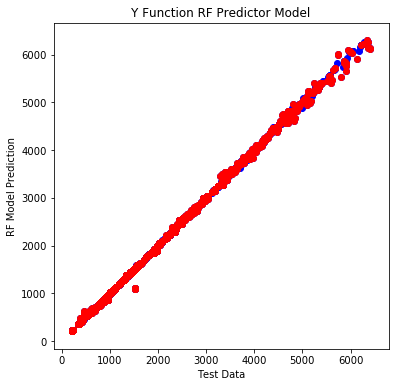

In [17]:
# make a cross plot of predicted and actual values
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
plt.scatter(y[clust_df.index.tolist()], pred_y_RF_all, c="blue", label="All - Filtered")
plt.scatter(test_y, pred_y_RF_test, c="red", label="Blind-Test")
ax.set(xlabel="Test Data", ylabel="RF Model Prediction", title="Y Function RF Predictor Model")
plt.show()
fig.savefig('rf_xplot.png', dpi=300)

In [18]:
# #############################################################################
### Gradient Boosting regression
# #############################################################################
model_GBM = ensemble.GradientBoostingRegressor(n_estimators= 500, 
                                               max_depth= 4, 
                                               min_samples_split= 2, 
                                               learning_rate= 0.01, 
                                               loss='ls',
                                               random_state=123)
model_GBM.fit(train_X, train_y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=123, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [19]:
# Predict for blind test and train input features
pred_y_GBM_train = model_GBM.predict(train_X)
pred_y_GBM_test = model_GBM.predict(test_X)
pred_y_GBM_all = model_GBM.predict(X.iloc[clust_df.index.tolist(),:])

In [20]:
# Compute  r2 scores  
r2_GBM_train = r2_score(train_y, pred_y_GBM_train)
r2_GBM_test = r2_score(test_y, pred_y_GBM_test) 
r2_GBM_all = r2_score(y[clust_df.index.tolist()], pred_y_GBM_all)
print("R^2 for train data GBM is %f." %r2_GBM_train)
print("R^2 for blind test data GBM is %f." %r2_GBM_test)
print("R^2 for all data GBM is %f." %r2_GBM_all)

R^2 for train data GBM is 0.995428.
R^2 for blind test data GBM is 0.992874.
R^2 for all data GBM is 0.994193.


In [21]:
# Add Random GBM Prediction to X_merge file 
all_pred = np.array([np.nan for i in range(len(X_merge))])
all_pred[clust_df.index.tolist()] = pred_y_GBM_all
X_merge["Predicted_GBM"] = all_pred
X_merge.to_csv("X_merge.csv", index=False)

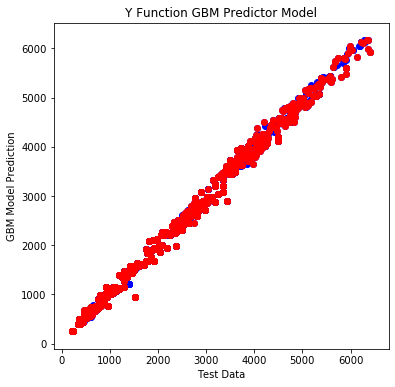

In [22]:
# make a cross plot of predicted and actual values
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
plt.scatter(y[clust_df.index.tolist()], pred_y_GBM_all, c="blue", label="All - Filtered")
plt.scatter(test_y, pred_y_GBM_test, c="red", label="Blind-Test")
ax.set(xlabel="Test Data", ylabel="GBM Model Prediction", title="Y Function GBM Predictor Model")
plt.show()
fig.savefig('gbm_xplot.png', dpi=300)